# Libraries and data load

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


# EDA

Look at the fuel_efficiency_mpg variable. Does it have a long tail?

<Axes: >

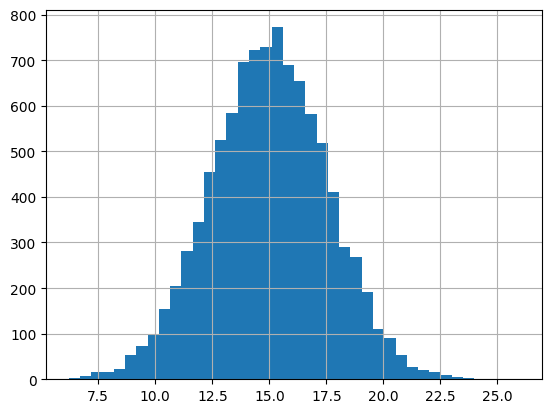

In [4]:
df.fuel_efficiency_mpg.hist(bins=40)

# Questions

### Q1: There's one column with missing values. What is it?

In [5]:
null_counts_per_column = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].isnull().sum()
print(null_counts_per_column[null_counts_per_column > 0])

horsepower    708
dtype: int64


### Q2: What's the median (50% percentile) for variable 'horsepower'?

In [6]:
print('Median   :  ', df.horsepower.median())

Median   :   149.0


### Shuffle and split dataset

In [7]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [8]:
print('Total rows       :   ', n)
print('Test train       :   ', n_train)
print('Test set         :   ', n_test)
print('Test validation  :   ',n_val)

Total rows       :    9704
Test train       :    5824
Test set         :    1940
Test validation  :    1940


In [9]:
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

In [10]:
idx = np.arange(n)

In [11]:
np.random.seed(42)
np.random.shuffle(idx)

In [12]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

In [13]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [14]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

### Q3: Simple regression

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [15]:
def train_linear_regression(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)

    ones = np.ones((X.shape[0], 1))
    X = np.hstack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


In [16]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    #return np.round(np.sqrt(mse), 2)
    return np.sqrt(mse)

In [17]:
numeric_cols =  [col for col in df.columns if col not in ['origin', 'fuel_type', 'drivetrain', 'fuel_efficiency_mpg']]

In [18]:
df_train_zero_fill = df_train[numeric_cols].fillna(0)

df_train_mean_fill = df_train[numeric_cols]

for col in numeric_cols:
    df_train_mean_fill[col] = df_train_mean_fill[col].fillna(df_train_mean_fill[col].mean())

/tmp/ipykernel_14826/2953154133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_mean_fill[col] = df_train_mean_fill[col].fillna(df_train_mean_fill[col].mean())


In [19]:
filled_dfs = [df_train_zero_fill, df_train_mean_fill]
rmse_list = []

for filled_df in filled_dfs:
    w0, w = train_linear_regression(filled_df, y_train)

    X_val = df_val[numeric_cols].fillna(0)
    y_pred = w0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))

#### Result

In [20]:
if rmse_list[0] > rmse_list[1]:
    ans = "With mean"
elif rmse_list[0] == rmse_list[1]:
    ans = "Both are equally good"
else:
    ans = 'With 0'

print('Zero fill    :   ', rmse_list[0])
print('Mean fill    :   ', rmse_list[1])

print('\nAnswer       :   ', ans)

Zero fill    :    0.506129494496294
Mean fill    :    0.7105447418429099

Answer       :    With 0


### Q4: Regularized regression

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [21]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + (r * np.eye(XTX.shape[0]))

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [22]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [23]:
rmse_reg_list = []

for r in r_list:
    w0, w = train_linear_regression_reg(df_train_zero_fill, y_train, r)

    X_val = df_val[numeric_cols].fillna(0)
    y_pred = w0 + X_val.dot(w)
    rmse_reg_list.append(rmse(y_val, y_pred))

In [24]:
for i in range(len(r_list)):
    print(r_list[i], '  :   ', rmse_reg_list[i])

0   :    0.506129494496294
0.01   :    0.505991133555381
0.1   :    0.5081011164006243
1   :    0.5119199936226153
5   :    0.5126253282950013
10   :    0.5127213126370691
100   :    0.5128069392520602


In [25]:
print('Lowest RMSE')
print(f'{r_list[rmse_reg_list.index(min(rmse_reg_list))]} :',min(rmse_reg_list))

Lowest RMSE
0.01 : 0.505991133555381


### Question 5: Seed
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [26]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
seed_rmse_list = []

all_numeric_cols =  [col for col in df.columns if col not in ['origin', 'fuel_type', 'drivetrain']]

In [27]:
def shuffle_df(df, seed):
    df_train = df.iloc[:n_train]
    df_val = df.iloc[n_train:n_train+n_val]
    df_test = df.iloc[n_train+n_val:]

    idx = np.arange(n)

    np.random.seed(seed=seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [28]:
for seed in seed_list:
    df_train, df_val, df_test, y_train, y_val, y_test = shuffle_df(df[all_numeric_cols], seed)
    
    filled_df = df_train.fillna(0)

    w0, w = train_linear_regression(filled_df, y_train)

    X_val = df_val[numeric_cols].fillna(0)
    y_pred = w0 + X_val.dot(w)
    seed_rmse_list.append(rmse(y_val, y_pred))

In [29]:
print('Standard deviation of all RMSE   :   ', np.round(np.std(seed_rmse_list), 3))

Standard deviation of all RMSE   :    0.007


### Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [30]:
df_train, df_val, df_test, y_train, y_val, y_test = shuffle_df(df[all_numeric_cols], 9)

In [31]:
df_train = pd.concat([df_train, df_val], ignore_index=True)
y_train = np.concatenate([y_train, y_val])

In [ ]:
filled_df = df_train.fillna(0)

w0, w = train_linear_regression_reg(filled_df, y_train, r=0.001)

X_val = df_test[numeric_cols].fillna(0)
y_pred = w0 + X_val.dot(w)

In [33]:
print('RMSE :   ', rmse(y_val, y_pred))

RMSE :    3.5081218070868534
